In [5]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
path = Path.cwd()/'data'
new_path=Path.cwd()/'data_split'
answers = pd.read_csv('answers.csv')

In [7]:
whales = answers[answers['label']==1]
no_whales= answers[answers['label']==0]
no_whales_x_train, no_whales_x_val, no_whales_y_train, no_whales_y_val = train_test_split( no_whales[['image_path2']], no_whales.label, test_size=0.2, random_state=10)
whales_x_train, whales_x_val, whales_y_train, whales_y_val = train_test_split( whales[['image_path2','name']], whales.label, test_size=0.2, random_state=10)

In [263]:
# import subprocess

# for i, row in whales_x_train.iterrows():
#     subprocess.call(["cp", row[0], new_path/'training'/'whale' ])
    
# for i, row in whales_x_val.iterrows():
#     subprocess.call(["cp", row[0], new_path/'validation'/'whale'])    


In [265]:
# for i, row in no_whales_x_train.iterrows():
#     subprocess.call(["cp", row[0], new_path/'training'/'no_whale'])

In [266]:
# for i, row in no_whales_x_val.iterrows():
#     subprocess.call(["cp", row[0], new_path/'validation'/'no_whale'])

In [14]:
datagen = ImageDataGenerator()
images_directory = new_path
cb_training = datagen.flow_from_directory(images_directory/'training', class_mode='binary')
cb_validation = datagen.flow_from_directory(images_directory/'validation', class_mode='binary')


Found 23194 images belonging to 2 classes.
Found 6001 images belonging to 2 classes.


In [11]:
def import_data():
    datagen = ImageDataGenerator()
    new_path=Path.cwd()/'data_split'
    images_directory = new_path
    cb_training = datagen.flow_from_directory(images_directory/'training', class_mode='binary',target_size=(97,97), batch_size=128 )
    cb_validation = datagen.flow_from_directory(images_directory/'validation', class_mode='binary',target_size=(97,97), batch_size=128 )
    no_whales_x_train, no_whales_x_val, no_whales_y_train, no_whales_y_val = train_test_split( no_whales[['image_path2']], no_whales.label, test_size=0.2, random_state=10)
    whales_x_train, whales_x_val, whales_y_train, whales_y_val = train_test_split( whales[['image_path2','name']], whales.label, test_size=0.2, random_state=10)
    return (cb_training, whales_y_train, cb_validation, whales_y_val)


def base_set_up(filename, patience=2):
    
    xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
    class_weight = dict(zip(np.unique(answers.label), xx))
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    earlystop = EarlyStopping(monitor='val_accuracy',verbose=1, patience=patience)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True,save_weights_only=False, verbose=1)
    return (class_weight, METRICS, earlystop, checkpoint)

# CNN Adding a small layer 

In [14]:
# cnn = None
# keras.backend.clear_session()
# filename = 'cnn_small_layer.h5'

# cb_training, training_labels, cb_validation, val_labels  = import_data()
# class_weight, METRICS, earlystop, checkpoint = base_set_up(filename, 5)

# cnn = Sequential()
# cnn.add(InputLayer(input_shape=(97,97, 3)))
# cnn.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=40, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=50, kernel_size=3, activation='relu', padding='same'))
# cnn.add(GlobalAveragePooling2D())


# cnn.add(layers.Dense(20, activation='relu'))
# cnn.add(layers.Dense(100, activation='relu'))
# cnn.add(layers.Dense(100, activation='relu'))
# cnn.add(layers.Dense(100, activation='relu'))


# cnn.add(layers.Dense(1, activation='sigmoid'))
# optimizer = Adam(learning_rate=0.00001)

# cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=METRICS)

# history = cnn.fit(cb_training, epochs=20,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])
history2 = cnn.fit(cb_training, epochs=20,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])



Epoch 1/20
182/182 [==============================] - 87s 478ms/step - loss: 0.3392 - tp: 4158.0000 - fp: 3006.0000 - tn: 15372.0000 - fn: 658.0000 - accuracy: 0.8420 - precision: 0.5804 - recall: 0.8634 - auc: 0.9214 - prc: 0.7353 - val_loss: 0.2466 - val_tp: 628.0000 - val_fp: 207.0000 - val_tn: 2137.0000 - val_fn: 75.0000 - val_accuracy: 0.9074 - val_precision: 0.7521 - val_recall: 0.8933 - val_auc: 0.9596 - val_prc: 0.8765

Epoch 00001: val_accuracy improved from 0.90023 to 0.90745, saving model to cnn_small_layer.h5
Epoch 2/20
182/182 [==============================] - 87s 477ms/step - loss: 0.3360 - tp: 4150.0000 - fp: 2969.0000 - tn: 15409.0000 - fn: 666.0000 - accuracy: 0.8433 - precision: 0.5829 - recall: 0.8617 - auc: 0.9230 - prc: 0.7397 - val_loss: 0.2530 - val_tp: 643.0000 - val_fp: 232.0000 - val_tn: 2112.0000 - val_fn: 60.0000 - val_accuracy: 0.9042 - val_precision: 0.7349 - val_recall: 0.9147 - val_auc: 0.9608 - val_prc: 0.8799

Epoch 00002: val_accuracy did not improve

182/182 [==============================] - 94s 518ms/step - loss: 0.2888 - tp: 4311.0000 - fp: 2678.0000 - tn: 15700.0000 - fn: 505.0000 - accuracy: 0.8628 - precision: 0.6168 - recall: 0.8951 - auc: 0.9424 - prc: 0.7961 - val_loss: 0.2126 - val_tp: 655.0000 - val_fp: 199.0000 - val_tn: 2145.0000 - val_fn: 48.0000 - val_accuracy: 0.9189 - val_precision: 0.7670 - val_recall: 0.9317 - val_auc: 0.9731 - val_prc: 0.9099

Epoch 00017: val_accuracy did not improve from 0.93338
Epoch 18/20
182/182 [==============================] - 85s 468ms/step - loss: 0.2879 - tp: 4321.0000 - fp: 2655.0000 - tn: 15723.0000 - fn: 495.0000 - accuracy: 0.8642 - precision: 0.6194 - recall: 0.8972 - auc: 0.9426 - prc: 0.7963 - val_loss: 0.2227 - val_tp: 665.0000 - val_fp: 227.0000 - val_tn: 2117.0000 - val_fn: 38.0000 - val_accuracy: 0.9130 - val_precision: 0.7455 - val_recall: 0.9459 - val_auc: 0.9735 - val_prc: 0.9117

Epoch 00018: val_accuracy did not improve from 0.93338
Epoch 19/20
182/182 [===============

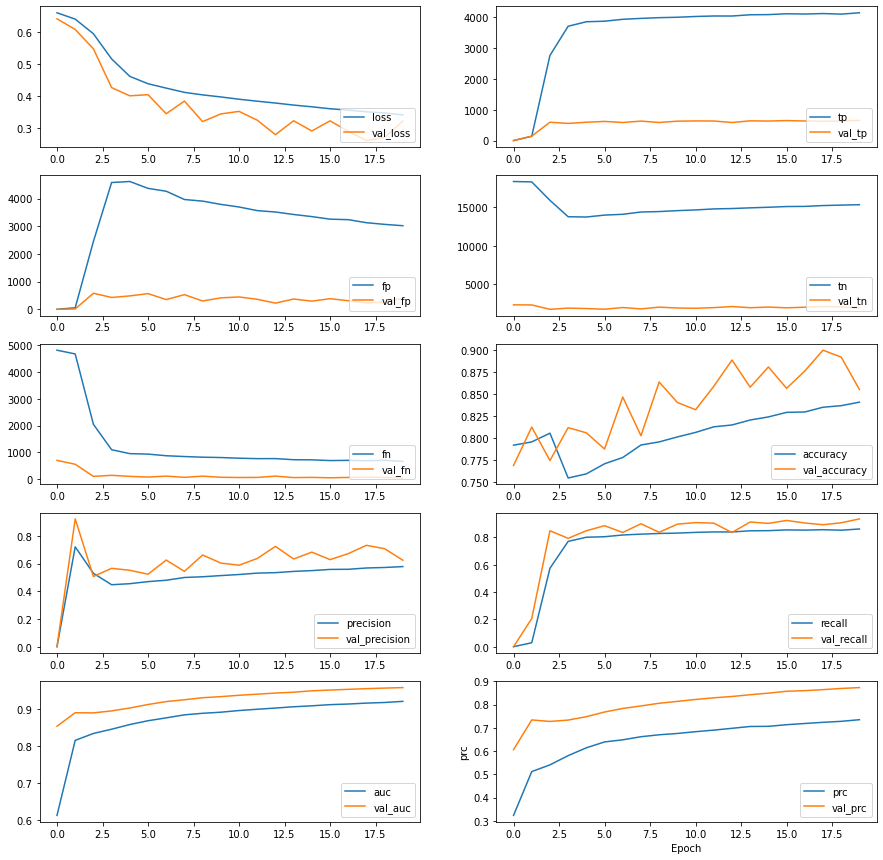

In [13]:
hist = history.history
hist2 = history2.history
all_keys = list(hist.keys())

fig, axes = plt.subplots(5,2, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
        key = all_keys[i]
        val_key = 'val_'+key
        ax.plot(hist[key]+hist2[key], label=key)
        ax.plot(hist[val_key]+hist2[val_key], label = val_key)
        plt.xlabel('Epoch')
        plt.ylabel(key)
        ax.legend(loc='lower right')

# Analysis 

Val Recall is dropping like a rock - thats bad.  
Val loss is slowly growing.  
Val accuracy is leveled off - we're not seeing a drop, but with the other values getting worse, and our misbalanced sets, Im ok with that.  
Val auc is dropping off. 

## Are we overfitting? 
Yes. 

## What shall we do next? 
That recall is concerning. Lets inspect the confusion matrix 